<a href="https://colab.research.google.com/github/cfitzpatrick89/ADS509-Final/blob/main/Descriptive_Statistics_ADS509_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import xmltodict
import requests
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
import json
from sklearn.decomposition import NMF
import gensim
from gensim import corpora
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.gensim_models
from sklearn.cluster import KMeans

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import nltk
nltk.download('vader_lexicon')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
# !pip install xmltodict
# !pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create Directory

In [6]:
# Function to create a directory
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Pubmed IDs

In [14]:
import requests

def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

# Example usage:
pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
def fetch_pubmed_details(ids, batch_size=100):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    xml_data_list = []
    for i in range(0, len(ids), batch_size):
        batch_ids = ids[i:i + batch_size]
        fetch_params = {
            "db": "pubmed",
            "id": ",".join(batch_ids),
            "retmode": "xml"
        }
        response = requests.get(fetch_url, params=fetch_params)
        if response.status_code == 200:
            xml_data_list.append(response.text)
        else:
            print(f"Error fetching PubMed details for batch {i//batch_size + 1}: {response.status_code} - {response.reason}")
    return xml_data_list

# Example usage:
pubmed_xml = fetch_pubmed_details(pubmed_ids)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Parse Data

In [16]:
import xmltodict

def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    else:
        return abstract

def parse_pubmed_details(xml_data_list):
    articles = []
    for xml_data in xml_data_list:
        data_dict = xmltodict.parse(xml_data)
        for article in data_dict['PubmedArticleSet']['PubmedArticle']:
            try:
                pmid = article['MedlineCitation']['PMID']
                title = article['MedlineCitation']['Article']['ArticleTitle']
                abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
                abstract_text = extract_text_from_abstract(abstract)
                articles.append({
                    'PMID': pmid,
                    'Title': title,
                    'Abstract': abstract_text
                })
            except KeyError:
                continue
    return articles

# Example usage:
articles = parse_pubmed_details(pubmed_xml)
df_articles = pd.DataFrame(articles)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# # Function to extract text from abstract field in different formats
# def extract_text_from_abstract(abstract):
#     print(f"Extracting text from abstract: {abstract}")  # Debug statement
#     if isinstance(abstract, list):
#         text_list = []
#         for item in abstract:
#             if isinstance(item, dict):
#                 text_list.append(item.get('#text', ''))
#             else:
#                 text_list.append(item)
#         extracted_text = ' '.join(text_list)
#     elif isinstance(abstract, dict):
#         extracted_text = abstract.get('#text', '')
#     else:
#         extracted_text = abstract
#     print(f"Extracted text: {extracted_text[:60]}...")  # Debug statement
#     return extracted_text

# # Function to parse PubMed XML Data in batches
# def parse_pubmed_details(xml_data_list):
#     articles = []
#     for batch_index, xml_data in enumerate(xml_data_list):
#         try:
#             print(f"Parsing batch {batch_index + 1}/{len(xml_data_list)}")  # Debug statement
#             data_dict = xmltodict.parse(xml_data)
#             for article in data_dict['PubmedArticleSet']['PubmedArticle']:
#                 try:
#                     pmid = article['MedlineCitation']['PMID']
#                     title = article['MedlineCitation']['Article']['ArticleTitle']
#                     abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
#                     abstract_text = extract_text_from_abstract(abstract)
#                     articles.append({
#                         'PMID': pmid,
#                         'Title': title,
#                         'Abstract': abstract_text
#                     })
#                     print(f"Article parsed: PMID {pmid}, Title {title[:60]}...")  # Debug statement
#                 except KeyError as e:
#                     print(f"KeyError: {e} - Skipping article")  # Debug statement
#                     continue
#         except Exception as e:
#             print(f"Error parsing XML: {e} - Skipping batch")  # Debug statement
#             continue
#     return articles



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocess Text

In [17]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Example usage:
df_articles['processed_abstract'] = df_articles['Abstract'].apply(preprocess_text)
df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# # Function to preprocess text without debug output
# def preprocess_text(text):
#     tokens = word_tokenize(text)
#     tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
#     return tokens

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# # Function to preprocess text
# def preprocess_text(text):
#     print(f"Preprocessing text: {text[:60]}...")  # Print the first 60 characters of the text for debugging
#     tokens = word_tokenize(text)  # Tokenize the text
#     print(f"Tokens: {tokens[:10]}...")  # Print the first 10 tokens for debugging
#     tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
#     print(f"Lowercased Tokens: {tokens[:10]}...")  # Print the first 10 lowercased tokens for debugging
#     tokens = [word for word in tokens if word.isalpha()]  # Remove tokens that contain non-alphabetic characters
#     print(f"Alphabetic Tokens: {tokens[:10]}...")  # Print the first 10 alphabetic tokens for debugging
#     tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
#     print(f"Tokens without Stopwords: {tokens[:10]}...")  # Print the first 10 tokens without stopwords for debugging
#     return tokens



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Descriptive Statistics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of tokens: 12966
Number of unique tokens: 3782
Average token length: 7.28
Most common tokens: [('health', 181), ('climate', 179), ('the', 137), ('change', 137), ('we', 84), ('research', 70), ('heat', 62), ('study', 54), ('exposure', 54), ('temperature', 52)]


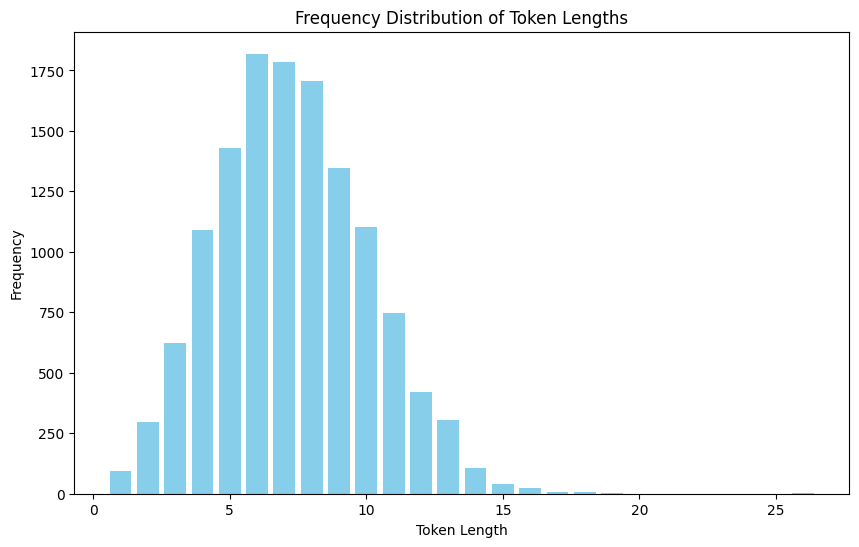

In [18]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

def calculate_descriptive_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    num_tokens = len(tokens)
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)
    avg_token_length = sum(len(token) for token in tokens) / num_tokens
    token_freq = Counter(tokens)
    most_common_tokens = token_freq.most_common(10)
    token_length_freq = Counter(len(token) for token in tokens)

    print(f"Number of tokens: {num_tokens}")
    print(f"Number of unique tokens: {num_unique_tokens}")
    print(f"Average token length: {avg_token_length:.2f}")
    print(f"Most common tokens: {most_common_tokens}")

    token_length_df = pd.DataFrame(token_length_freq.items(), columns=['Token Length', 'Frequency']).sort_values(by='Token Length')
    return token_length_df

# Example usage:
token_length_df = calculate_descriptive_statistics(df_articles, 'processed_abstract_str')

# Plot the frequency distribution of token lengths
plt.figure(figsize=(10, 6))
plt.bar(token_length_df['Token Length'], token_length_df['Frequency'], color='skyblue')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Token Lengths')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average number of unique tokens per abstract: 100.38
Average sentence length: 137.94 tokens


<ipython-input-19-14d0b48db03f>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Token', y='Frequency', data=token_freq_df, palette='viridis')


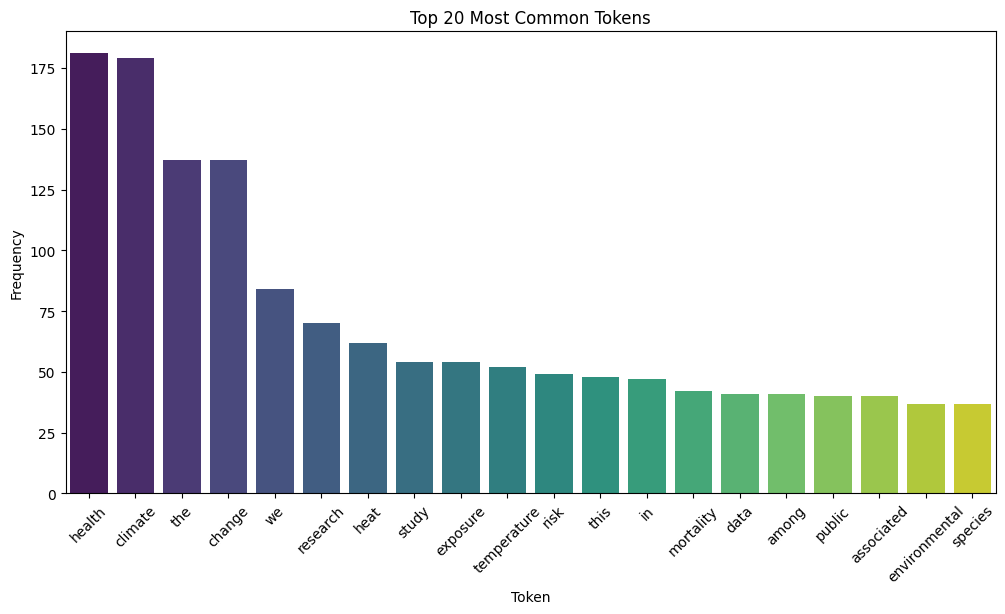

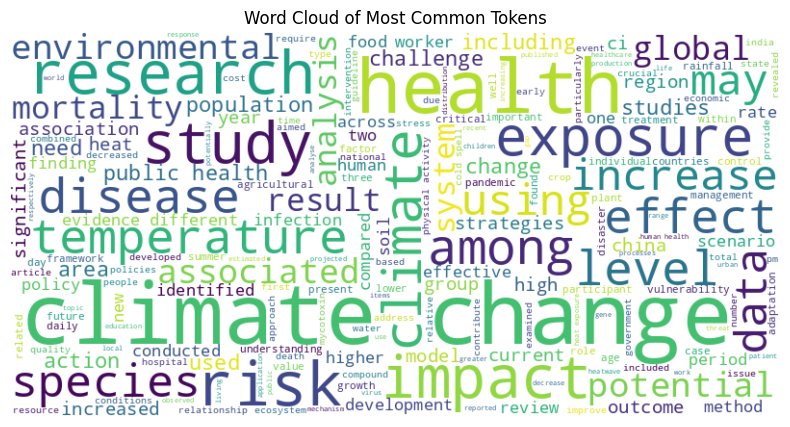

In [19]:
import numpy as np
from wordcloud import WordCloud

def calculate_advanced_statistics(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)

    # Token frequency distribution
    token_freq = Counter(tokens)

    # Unique tokens per abstract
    df['unique_tokens'] = df[text_column].apply(lambda x: len(set(word_tokenize(x))))
    avg_unique_tokens = df['unique_tokens'].mean()

    # Average sentence length
    sentences = [sentence for text in df[text_column] for sentence in text.split('.')]
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    avg_sentence_length = np.mean(sentence_lengths)

    # Display results
    print(f"Average number of unique tokens per abstract: {avg_unique_tokens:.2f}")
    print(f"Average sentence length: {avg_sentence_length:.2f} tokens")

    # Token frequency distribution plot
    token_freq_df = pd.DataFrame(token_freq.most_common(20), columns=['Token', 'Frequency'])
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Token', y='Frequency', data=token_freq_df, palette='viridis')
    plt.xlabel('Token')
    plt.ylabel('Frequency')
    plt.title('Top 20 Most Common Tokens')
    plt.xticks(rotation=45)
    plt.show()

    # Word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Most Common Tokens')
    plt.show()

    return avg_unique_tokens, avg_sentence_length

# Example usage:
if df_articles is not None:
    df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))
    avg_unique_tokens, avg_sentence_length = calculate_advanced_statistics(df_articles, 'processed_abstract_str')
else:
    print("DataFrame is empty. No articles to process.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


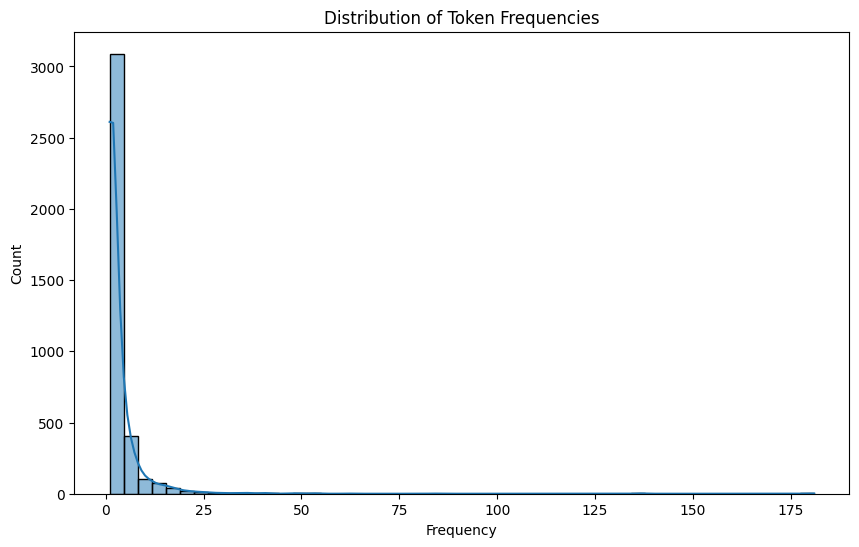

In [20]:
def plot_token_frequencies(df, text_column):
    all_text = " ".join(df[text_column])
    tokens = word_tokenize(all_text)
    token_freq = Counter(tokens)

    token_freq_df = pd.DataFrame(token_freq.values(), columns=['Frequency'])
    plt.figure(figsize=(10, 6))
    sns.histplot(token_freq_df['Frequency'], bins=50, kde=True)
    plt.xlabel('Frequency')
    plt.ylabel('Count')
    plt.title('Distribution of Token Frequencies')
    plt.show()

# Example usage:
plot_token_frequencies(df_articles, 'processed_abstract_str')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


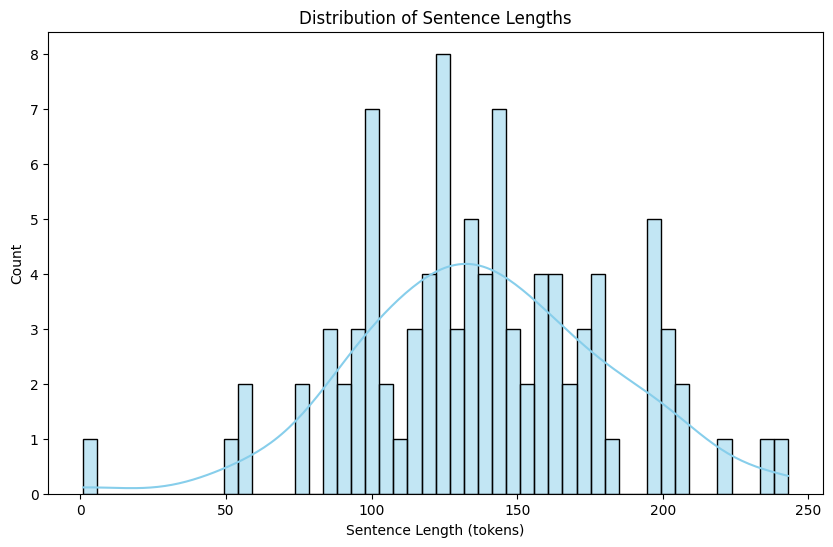

In [21]:
def plot_sentence_lengths(df, text_column):
    sentences = [sentence for text in df[text_column] for sentence in text.split('.')]
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]

    plt.figure(figsize=(10, 6))
    sns.histplot(sentence_lengths, bins=50, kde=True, color='skyblue')
    plt.xlabel('Sentence Length (tokens)')
    plt.ylabel('Count')
    plt.title('Distribution of Sentence Lengths')
    plt.show()

# Example usage:
plot_sentence_lengths(df_articles, 'processed_abstract_str')
